In [2]:
%run ./funcoes.ipynb

In [4]:
from sklearn.model_selection import train_test_split
#Carga dos dados já parcialmente tratados
arquivo_base = "INFLUD21-29-03-2021.csv"  
ext_file = "_processed_pre_dummies.csv"
rad_filename = arquivo_base[:-4]  #exclui a extensão do arquivo
filename_pre_des = rad_filename + ext_file
covid_df = load_df(filename_pre_des,";",None,None)  #carrega os dados

Arquivo informado: INFLUD21-29-03-2021.csv
Verifica existencia do arquivo: True
Arquivo INFLUD21-29-03-2021_143_proc_smote_over.csv foi encontrado.
Carregando o arquivo...
Concluído.


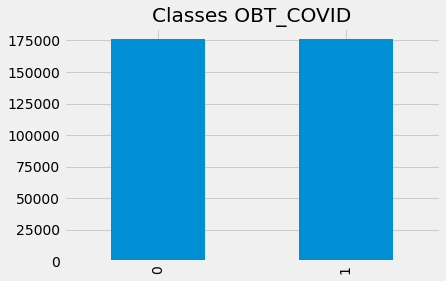

In [6]:
#Converte os tipos das variaveis do dataframe
covid_df_cat = converte_tipo_category(covid_df)
#Converte as variáveis categóricas em binárias (dummies)
covid_df_bin = converte_binarios(covid_df_cat) 
#Normalizada as colunas contínuas
covid_df_nor = normaliza_dados(covid_df_bin)
# Balanceamento da base de desenvolvimento Com SMOTE oversampling
covid_df_train_bal = imblearn_SMOTE_oversampling(covid_df_nor,arquivo_base,False,'OBT_COVID')

In [8]:
labels = covid_df_train_bal.columns[:-1]  # presume-se que a última variável do dataframe é a alvo
X = covid_df_train_bal[labels]
y = covid_df_train_bal['OBT_COVID']

In [10]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42,
  shuffle=True, stratify=y)

In [12]:
covid_df_train_bal

,NU_IDADE_N,GeoSES,AN_SARS2_1.0,AN_SARS2_9.0,ASMA_1.0,ASMA_2.0,ASMA_9.0,CARDIOPATI_1.0,CARDIOPATI_2.0,CARDIOPATI_9.0,...,UTI_1.0,UTI_2.0,UTI_9.0,VACINA_1.0,VACINA_2.0,VACINA_9.0,VOMITO_1.0,VOMITO_2.0,VOMITO_9.0,OBT_COVID
0,0.646154,0.662604,0,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0.546154,0.662604,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
2,0.669231,0.662604,0,1,0,1,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
3,0.600000,0.662604,0,1,0,1,0,1,0,0,...,0,0,1,0,0,1,0,1,0,1
4,0.661538,0.662604,0,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351835,0.507239,0.562543,0,1,0,0,1,0,0,1,...,1,0,0,0,1,0,0,0,1,1
351836,0.466494,0.481421,0,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,1
351837,0.491169,0.546128,0,1,0,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,1
351838,0.561398,0.482540,0,1,0,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,1


In [14]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Inicializa o classificador
xgb_cl = xgb.XGBClassifier(objective="binary:logistic", verbose=None, seed=1121218)

# Treina
xgb_cl.fit(X_train, y_train)

[22:02:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              random_state=1121218, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=1121218, subsample=1,
              tree_method='exact', validate_parameters=1, verbose=None,
              verbosity=None)

In [16]:
# Predict
preds = xgb_cl.predict(X_test)

#usar em bases desbalanceadas

 #"scale_pos_weight": [scale_pos_weight],  # Fix scale_pos_weight

In [18]:

param_grid_2 = {
    "max_depth": [3, 4, 5],
    "gamma": [5, 30, 50],
    "learning_rate": [0.01, 0.1, 0.3, 0.5],
    "min_child_weight": [1, 3, 5],
    "reg_lambda": [50, 100, 300],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
}

In [20]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

halving_random_cv = HalvingRandomSearchCV(
    xgb_cl, param_grid_2, scoring="roc_auc", n_jobs=-1, n_candidates="exhaust", factor=4
)

xgb_CV = halving_random_cv.fit(X, y)



C:\Users\02373373718\Anaconda3\envs\Pycaret\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2916 is smaller than n_iter=17592. Running 2916 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\02373373718\Anaconda3\envs\Pycaret\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[22:38:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [22]:
halving_random_cv.best_score_

0.8993483402645861

In [24]:
xgb_CV.best_params_

{'subsample': 0.8,
 'reg_lambda': 50,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.5,
 'gamma': 5,
 'colsample_bytree': 0.8}